# Exercise: Taxonomy Induction

<br>
In this exercise, we will perform the various steps commonly employed for unsupervised taxonomy induction from text corpora. Taxonomy induction from text typically consists of three main steps:

<ol>
  <li><b>Relations Extraction:</b> In this step, we use lexico-syntactic patterns to extract <b>IsA</b> relations from text. An example of IsA relation is (<i>apple, fruit</i>), which implies that <i>apple</i> is a type of fruit.</li>
  <br>
  <li><b>Initial Graph Construction:</b> In this step, we aggregate the extracted IsA relations to construct a potentially-noisy initial hypernym graph.</li>
  <br>
  <li><b>Graph Pruning:</b> In the final step, we perform some pruning or optimization steps to induce the a final clean taxonomy.</li>
</ol>  

<br>
We will describe these steps in detail in the rest of this exercise. 


## Question 1 - Relations Extraction


In this part of the exercise, we will run a small-scale extraction of IsA relations and inspect the results. Relations extraction uses lexico-syntactic patterns to identify IsA relations from unstructured text. Examples of lexico-syntactic patterns include:

 Lexico-syntactic pattern | Sample matching text
  ------|------------------
  <b>X</b> is a <b>Y</b>     | <i><b>apple</b> is a <b>fruit</b></i>, <i><b>switzerland</b> is a <b>country</b></i>
  <b>X</b> such as <b>Y</b>     | <i><b>fruits</b> such as <b>mango</b></i>, <i><b>scientists</b> such as <b>Einstein</b></i>
  <b>X</b> is an example of <b>Y</b>     | <i><b>iphone</b> is an example of <b>smartphone</b></i>
  
  <br>
  In this exercise, we will use such lexico-syntactic patterns to identify IsA relations from text.
  
  
  ###  Question 1.a

  Load the given file <b>wiki_food_en.txt</b> into memory using the following code:
  
  
  

In [1]:
def load_text_file(filename):
    file_text = []
    with open(filename) as fp:
        for line in fp:
            file_text.append(line.strip().lower())
    return " ".join(file_text)

file_text = load_text_file("wiki_food_en.txt")

<br>
The following code uses the regular expression library to detect lexico-syntactic patterns in the file_text. The example below uses the regular expression "X is a Y". Fill in the blanks (...):


In [2]:
import re

def find_matches(file_text, regexp_string):
    #Compile a regular expression 
    regexp = re.compile(regexp_string)
    
    #Find all matches with the given regular expression
    matches = re.findall(regexp, file_text)
    
    return matches

isa_matches = find_matches(file_text, "[a-z]+ is a [a-z]+")

In [4]:
isa_matches[:20]

['word is a compound',
 'ajiaco is a popular',
 'ajiaco is a hearty',
 'ajiaco is a quite',
 'bana is a small',
 'hull is a reticulated',
 'but is a popular',
 'almond is a nutritionally',
 'serving is a rich',
 'oil is a rich',
 'and is a glyceryl',
 'hull is a reticulated',
 'but is a popular',
 'almond is a nutritionally',
 'serving is a rich',
 'oil is a rich',
 'and is a glyceryl',
 'it is a popular',
 'and is a popular',
 'it is a popular']

<br>
 ###  Question 1.b

Run the above code for relations extraction with the following lexico-syntactic patterns:

<ol>
  <li>X such as Y</li>
  <li>such X as Y</li>
<li>X and other Y</li>  
</ol>

Manually inspect the results and compute the accuracies of first 20 matches for each lexico-syntactic pattern. What do you observe? Is there any important difference between patterns no. 1,2 and 3? 

In [5]:
isa_matches_such_as = find_matches(file_text, "[a-z]+ such as [a-z]+")
isa_matches_such_as[:20]

['pig such as the',
 'beverages such as cocktails',
 'emulsifiers such as egg',
 'varieties such as allioli',
 'pests such as the',
 'ceremonies such as weddings',
 'pests such as navel',
 'versions such as the',
 'pests such as the',
 'ceremonies such as weddings',
 'pests such as navel',
 'versions such as the',
 'illnesses such as infections',
 'pans such as a',
 'manufacturing such as acetic',
 'aid such as modified',
 'session such as of',
 'plants such as pear',
 'foods such as apple',
 'cheeses such as cheddar']

In [6]:
isa_matches_such = find_matches(file_text, "such [a-z]+ as [a-z]+")
isa_matches_such[:20]

['such serves as an',
 'such flavors as chocolate',
 'such factors as territorial',
 'such countries as germany',
 'such foods as pizza',
 'such words as the',
 'such factors as territorial',
 'such companies as arienti',
 'such ingredients as water',
 'such ingredients as water',
 'such places as thailand',
 'such places as thailand',
 'such parameters as the',
 'such species as the',
 'such nougat as the',
 'such items as sliced',
 'such species as the',
 'such conditions as abscesses',
 'such plants as the',
 'such items as dry']

In [7]:
isa_matches_such_and_other = find_matches(file_text, "[a-z]+ and other [a-z]+")
isa_matches_such_and_other[:20]

['france and other countries',
 'figs and other recipes',
 'azerbaijan and other central',
 'olives and other tree',
 'azerbaijan and other central',
 'olives and other tree',
 'rye and other flours',
 'france and other european',
 'sauces and other sauces',
 'mixes and other gluten',
 'petals and other flower',
 'petals and other flower',
 'tariff and other supports',
 'wars and other fairtrade',
 'wine and other ingredients',
 'date and other agronomic',
 'soups and other foods',
 'patties and other bulk',
 'spices and other substances',
 'sugars and other components']

## Question 2 - Graph Construction

As you noticed in the previous step, the output of lexico-syntactic patterns-based relations extraction contains significant noise. The task of noise removal is fairly involved and beyond the scope of this exercise. For further reading, we recommend this paper, which demonstrates a state-of-the-art effort for IsA relations extraction (<a href="http://webdatacommons.org/isadb/lrec2016.pdf">A Large Database of Hypernymy Relations Extracted from the Web</a>).

In this part of the exercise, we assume that IsA relations extracted using a state-of-the-art approach are already available. Given these relations, the aim of this step is to construct an initial potentially-noisy hypernym graph.

###  Question 2.a


Load the IsA relations of the food domain from the given file "food_isa_relations.txt" using the following code:

In [8]:
rels = []
with open("food_isa_relations.txt") as fp:
    for line in fp.readlines():
        toks = line.strip().split('\t')
        rels.append((toks[0],toks[1],float(toks[2])))

In python, graphs are better handled as a default 2-level dictionary. For example, the edge (<i>apple</i>,<i>fruit</i>, freq) is represented as a two-level map:

map['apple']['fruit'] = freq

The following code converts the IsA relations loaded from the file into a 2-level dictionary. Fill in the blanks:

In [9]:
from collections import defaultdict

noisy_relations = defaultdict(dict)
for hypo, hyper, freq in rels:
    noisy_relations[hypo][hyper] = freq

<br>

###  Question 2.b

The next step of taxonomy induction involves removing and filtering out noisy IsA relations. In a real scenario, this usually involves a wide variety of steps. However, in this exercise, we will implement only one step. In this step, we will sort all the hypernyms for each hyponym, and only retain top-5 hypernyms for each hyponym.

First, print the hypernyms of 'apple':

In [16]:
noisy_relations['apple']

{'fruit': 1.0,
 'company': 0.547120747653,
 'apple': 0.41334243636,
 'orange': 0.155466692675,
 'food': 0.147812587177}

<br>
Fill in the blanks in the following code: 

In [17]:
for hypo in noisy_relations.keys():
    sorted_hypernyms = sorted(noisy_relations[hypo].items(), key = lambda x: x[1], reverse=True)
    noisy_relations[hypo] = {k:v for k,v in sorted_hypernyms[:5]}
    
# Printed filtered noisy relations.
noisy_relations['apple']   

{'fruit': 1.0,
 'company': 0.547120747653,
 'apple': 0.41334243636,
 'orange': 0.155466692675,
 'food': 0.147812587177}

###  Question 2.c

In the next step, we would first convert the set of filtered IsA relations into a graph. First install the library networkx and matplotlib:

   $ pip install networkx<br>
   
   $ pip install matplotlib
   


Further, use the following code:

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

for hypo in noisy_relations.keys():
    for hyper in noisy_relations[hypo].keys():
        G.add_edge(hypo, hyper)

In [21]:
for p in nx.all_simple_paths(G, 'apple', 'food'):
    print(p)

['apple', 'fruit', 'food']
['apple', 'fruit', 'ingredient', 'food']
['apple', 'orange', 'fruit', 'food']
['apple', 'orange', 'fruit', 'ingredient', 'food']
['apple', 'food']


In [22]:
for p in nx.all_simple_paths(G, 'fusilli', 'food'):
    print(p)

['fusilli', 'pasta', 'food']
['fusilli', 'pasta', 'dish', 'food']
['fusilli', 'pasta', 'ingredient', 'food']


In [23]:
for p in nx.all_simple_paths(G, 'okra', 'food'):
    print(p)

['okra', 'vegetable', 'food']
['okra', 'vegetable', 'ingredient', 'food']


<br>
Print all the paths between the following terms (Hint: use the networkx function all_simple_paths):

1. 'apple' and 'food'
2. 'fusilli' and 'food'
3.  'okra' and 'food' 

Do you notice any relationship between the length of the path and its accuracy?


###  Question 2.d

In this step, we will now build a taxonomy. We will undertake the following steps:

<ol>
  <li> Let the vocabulary be {'apple', 'mango', 'peach', 'orange', 'banana'}.</li> 
<li> Let the root of the taxonomy be 'food'.</li> 
<li> Find all simple paths between terms in the vocabulary and the root. </li>
<li> Retain all simple paths of length $l$.
<li> Construct a graph by aggregatiing all the edges in the retained paths. </li>

The below code implements the above steps. Fill in the blanks:


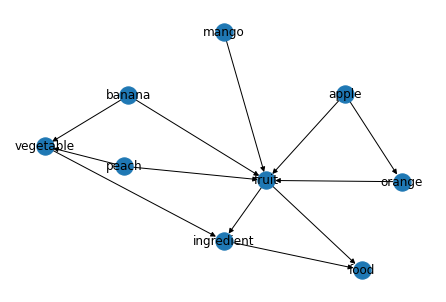

In [27]:
def select_paths(vocab, root, l):
    retained_paths = []
    for term in vocab:
        for path in nx.all_simple_paths(G, source=term, target=root):
            if len(path) == l:
                retained_paths.append(path)
    return retained_paths


def aggregate_paths(paths):
    agg_graph = defaultdict(dict)
    
    for path in paths:
        for i,term in enumerate(path[0:len(path) -1]):
            agg_graph[term][path[i+1]] = 1
            
    return agg_graph


V = ['apple', 'mango', 'peach', 'orange', 'banana']
root = 'food'

graph = aggregate_paths(select_paths(V, root, 4))
 

# Plot the graph
def plot_graph(graph):
    Gt = nx.DiGraph()
    for k in graph.keys():
        for k1 in graph[k].keys():
            Gt.add_edge(k,k1)
    nx.draw(Gt, with_labels=True)
    plt.show()
    
plot_graph(graph)

###  Question 2.e

Plot the aggregated graph using the previous steps but with different path lengths (For example, 2 or 4). What do you notice?

###  Question 2.f

Repeat steps from 2.b to 2.e but without filtering the noisy relations in step 2.b. What do you observe?